In [66]:
from setup import *
from agents import *
from env import *
gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps = '1001', 3, 3, 3, 1, 1, 9
disclosure = ['rnd', 'period', 'step','currentBid','currentAsk','buy','sell','price','sale']
buyerStrategies = ['ZeroIntelligence', 'ZeroIntelligence','ZeroIntelligence']
sellerStrategies = ['ZeroIntelligence', 'ZeroIntelligence','ZeroIntelligence']
metaData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, disclosure, buyerStrategies, sellerStrategies]
env = BaseEnv(metaData)
env.simulate()

In [67]:
import gymnasium as gym
from gymnasium import spaces

class SingleAgentEnv1(gym.Env):
    def __init__(self, metaData):
        self.gameData = metaData[0:7]
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps = self.gameData
        self.disclosure, self.buyerStrategies, self.sellerStrategies = metaData[7:]
        self.buyers, self.sellers = generateAgents(self.gameData,self.buyerStrategies,self.sellerStrategies,self.disclosure)
        self.log = Log(self.gameData, self.buyerStrategies, self.sellerStrategies, self.disclosure)
        self.roundData = roundSetup(*self.gameData)
        self.redemptionValues, self.tokenCosts, self.demand, self.supply, self.prices, self.peq, self.qeq  = self.roundData[0:7]
        [self.buyerReservationPrices, self.sellerReservationPrices, self.buyerSurplus, self.sellerSurplus, self.totalSurplus, self.buyerSurplusFrac, self.sellerSurplusFrac] = self.roundData[7:]
        self.log.addRound([0] + self.roundData)
        resetRounds(self.buyers, self.sellers, self.redemptionValues, self.tokenCosts)
        self.depth = 9
        self.numStates = 8 + 6 * self.depth
        self.action_space = spaces.Box(-1,1,(1,),dtype=np.float32)
        self.observation_space = spaces.Box(-1000,1000,(self.numStates,),dtype=np.float32)
        self.timePeriod = 0
        self.timeStep = 0

    def reset(self, seed = None):
        resetPeriods(self.buyers, self.sellers)
        resetSteps(self.buyers, self.sellers)
        agent = self.buyers[0]
        agentState = [self.timeStep, agent.stepTokenValue, agent.stepBid, agent.stepAsk, agent.stepTrades, agent.stepProfits, agent.periodTrades, agent.periodProfits]
        history = [-1, -1, -1, -1, -1, -1] * self.depth
        state = np.nan_to_num(np.array(agentState + history, dtype = np.float32), nan=-9)
        self.numStates = state.shape[0]
        return state, {}

    def step(self, action):
        # convert action into bid
        minBid = 0
        maxBid = 100
        frac = (action.item()+1)/2
        bids, asks = collectOffers(self.buyers, self.sellers)
        bids[0] = np.round(frac * minBid + (1-frac) * maxBid,1)

        # simulate market
        currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
        price, buy, sell = trade(self.buyers, self.sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
        bprofit, sprofit = 0, 0
        if price > 0:
            self.buyers[currentBidIdx].transact(price)
            self.sellers[currentAskIdx].transact(price)
            bprofit = self.buyers[currentBidIdx].stepProfits
            sprofit = self.sellers[currentAskIdx].stepProfits
        self.log.addStep([0, self.timePeriod, self.timeStep, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
        observe(self.buyers, self.sellers, self.log.disclose())

        # compute reward and transition
        reward = 0.0
        if price > 0 and currentBidIdx == 0:
            reward = np.nan_to_num(bprofit,nan=0)
        agent = self.buyers[0]
        agentState = [self.timeStep, agent.stepTokenValue, agent.stepBid, agent.stepAsk, agent.stepTrades, agent.stepProfits, agent.periodTrades, agent.periodProfits]
        history = self.buyers[0].df.iloc[-self.depth:][['currentBid', 'currentAsk', 'buy', 'sell', 'price', 'price']].values.reshape(-1,).tolist()
        if len(history) == (6 * self.depth):
            pass
        else:
            history = [-1] * (6 * self.depth)
        newState = np.nan_to_num(np.array(agentState + history, dtype = np.float32), nan=-9)
        # check termination
        if self.timeStep == self.numSteps - 1:
            terminated = True
            self.timePeriod += 1
            self.timeStep = 0
        else:
            self.timeStep += 1
            terminated = False
        infos = {"TimeLimit.truncated":True}
        truncated = False
        resetSteps(self.buyers, self.sellers)
        return newState, reward, terminated, truncated, infos

    def graphSales(self, rnd, period):
        fig, ax = graphMarket(*self.gameData, *self.log.getRoundList(rnd))
        periodBids, periodAsks, periodPrices, periodSales = self.log.getPeriodActivity(rnd,period)
        plt.plot(range(1,len(periodPrices)+1), periodPrices, color='darkgreen', linestyle='--', label='Actual Prices')
        print(np.array([periodBids[i][0] for i in range(self.numSteps) if periodPrices[i] > 0]))
        plt.plot([periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0],[periodBids[i][0] for i in range(self.numSteps) if periodPrices[i] > 0], color='darkorange', linestyle='--', label='Reinforcer Bids')
        for i in range(self.numSteps):
            if (periodPrices[i] > 0):
                ax.scatter(np.array([periodSales[i]] * len(periodBids[i][1:])), np.array(periodBids[i][1:]), s=10, alpha=0.5, c='purple')
                ax.scatter([periodSales[i]] * len(periodAsks[i]), periodAsks[i], s=10, alpha=0.5, c='blue')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.show()

    def graphOffers(self, rnd, period):
        periodBids, periodAsks, periodPrices, periodSales = self.log.getPeriodActivity(rnd,period)
        fig, ax = plt.subplots()
        ax.plot(np.array(periodBids)[:, 0], c='red', linestyle='--', label='Bids')
        ax.plot(np.array(periodBids)[:, 1:], c='purple', linestyle='--', label='Bids')
        ax.plot(periodAsks, c='darkgreen', linestyle='--', label='Asks')
        print(len(range(self.numSteps)))
        print(len(periodPrices))
        ax.scatter(range(self.numSteps), periodPrices, c='black', label='Prices')
        ax.set_title('Bids (red), Asks (blue), and Prices (green) over trading steps')
        plt.show()

### Check

In [68]:
from stable_baselines3.common.env_checker import check_env
env = SingleAgentEnv1(metaData)
check_env(env)

In [69]:
env.log.stepData

,rnd,period,step,bids,asks,currentBid,currentBidIdx,currentAsk,currentAskIdx,buy,sell,price,sale,bprofit,sprofit
0,0,0,0,"[30.3, 32.1, 51.3]","[nan, 75.2, 10.2]",51.3,2,10.2,2.0,1.0,1.0,30.75,True,62.35,25.15
1,0,0,1,"[69.7, 14.8, 77.2]","[nan, 65.5, 9.0]",77.2,2,9.0,2.0,1.0,1.0,43.10,True,50.00,37.50
2,0,0,2,"[41.9, 20.5, 35.7]","[nan, 56.0, 31.8]",41.9,0,31.8,2.0,1.0,1.0,36.85,True,63.15,14.55
3,0,0,3,"[33.3, 61.7, 6.7]","[nan, 61.7, 26.0]",61.7,1,26.0,2.0,1.0,1.0,43.85,True,33.35,18.15
4,0,0,4,"[70.1, 67.2, 44.1]","[nan, 65.5, nan]",70.1,0,65.5,1.0,1.0,1.0,67.80,True,15.50,27.40
5,0,0,5,"[41.4, 7.4, 9.8]","[nan, 69.9, nan]",41.4,0,69.9,1.0,0.0,0.0,NaN,False,0.00,0.00
6,0,0,6,"[21.6, 24.3, 28.9]","[nan, 52.1, nan]",28.9,2,52.1,1.0,1.0,0.0,52.10,True,0.70,8.20
7,0,0,7,"[44.5, 45.9, 2.8]","[nan, 69.8, nan]",45.9,1,69.8,1.0,1.0,0.0,69.80,True,3.80,23.00
8,0,0,8,"[13.6, 45.2, 12.5]","[nan, nan, nan]",45.2,1,NaN,NaN,NaN,NaN,NaN,False,0.00,0.00
9,0,1,0,"[66.4, 47.4, 28.6]","[nan, 63.8, 8.7]",66.4,0,8.7,2.0,True,True,37.55,True,62.45,31.95


### SB3

In [70]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, SAC
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.base_class import BaseAlgorithm
env = SingleAgentEnv1(metaData)
print(env.log.getRound(0).redemptionValues.item())
policy_kwargs = dict(net_arch=dict(pi=[256, 256], qf=[256, 256]))
model = SAC("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,)
model.learn(50000, progress_bar = True)

Output()

[[ 96.8  65.4  61.2]
 [100.   52.5  41.3]
 [ 99.   83.1  47.7]]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 20.9     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 215      |
|    time_elapsed    | 0        |
|    total_timesteps | 36       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 24.5     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 220      |
|    time_elapsed    | 0        |
|    total_timesteps | 72       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 28.1     |
| time/              |    

In [71]:
env.log.getPeriod(0,5550)

,rnd,period,step,bids,asks,currentBid,currentBidIdx,currentAsk,currentAskIdx,buy,sell,price,sale,bprofit,sprofit
49950,0,5550,0,"[84.6, 24.0, 71.8]","[4.2, nan, 25.7]",84.6,0,4.2,0.0,True,True,44.4,True,52.4,40.7
49951,0,5550,1,"[91.3, 42.8, 30.9]","[11.9, nan, 27.1]",91.3,0,11.9,0.0,True,True,51.6,True,13.8,40.8
49952,0,5550,2,"[65.0, 17.7, 69.6]","[78.4, nan, 24.2]",69.6,2,24.2,2.0,True,True,46.9,True,52.1,26.7
49953,0,5550,3,"[41.3, 56.9, 46.7]","[90.4, nan, 89.7]",56.9,1,89.7,2.0,True,True,73.3,True,26.7,23.3
49954,0,5550,4,"[4.0, 28.2, 64.0]","[96.6, nan, 67.6]",64.0,2,67.6,2.0,True,True,65.8,True,17.3,5.1
49955,0,5550,5,"[4.4, 38.0, 22.6]","[112.2, nan, nan]",38.0,1,112.2,0.0,False,False,NaN,False,0.0,0.0
49956,0,5550,6,"[4.7, 43.1, 14.6]","[88.7, nan, nan]",43.1,1,88.7,0.0,False,False,NaN,False,0.0,0.0
49957,0,5550,7,"[14.6, 15.0, 21.3]","[77.1, nan, nan]",21.3,2,77.1,0.0,False,False,NaN,False,0.0,0.0
49958,0,5550,8,"[16.8, 37.8, 42.1]","[84.2, nan, nan]",42.1,2,84.2,0.0,False,False,NaN,False,0.0,0.0


In [72]:
env.log.getRound(0).redemptionValues.item()

array([[ 96.8,  65.4,  61.2],
       [100. ,  52.5,  41.3],
       [ 99. ,  83.1,  47.7]])

[84.6 91.3 65.  41.3  4. ]


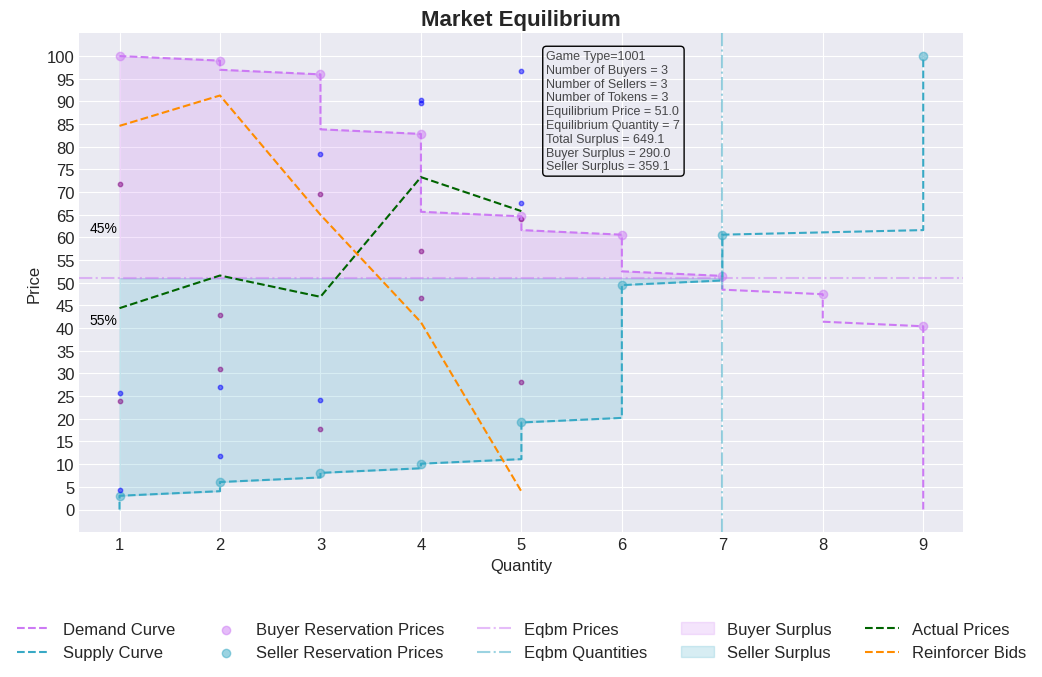

In [73]:
env.graphSales(0,5550)

[84.6 91.3 65.  41.3  4. ]


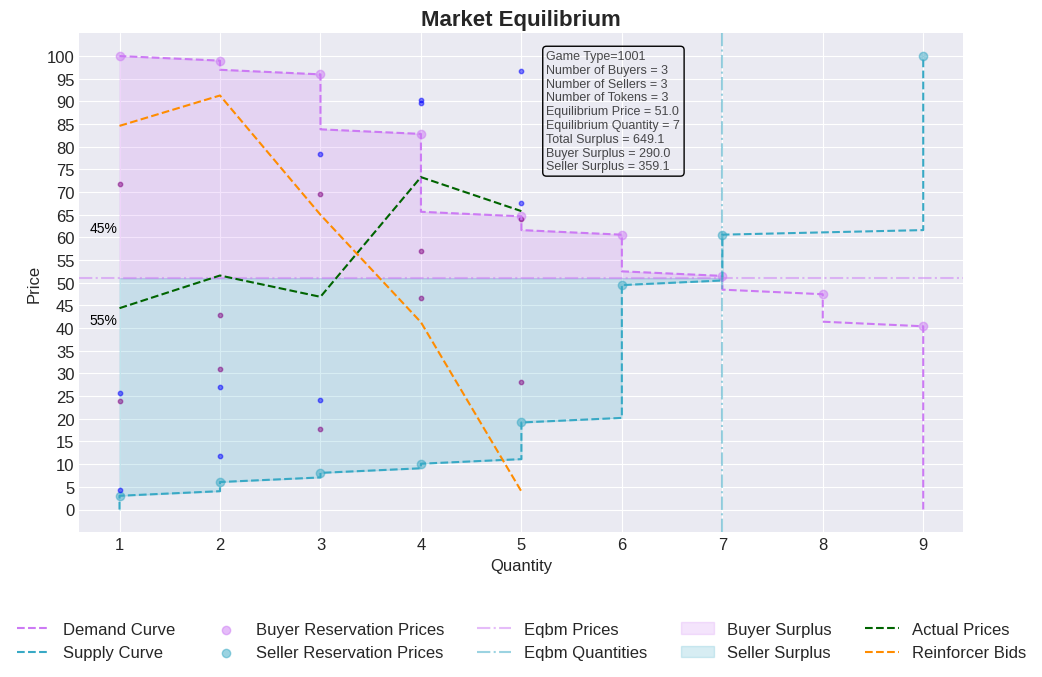

In [74]:
env.graphSales(0,5550)

9
9


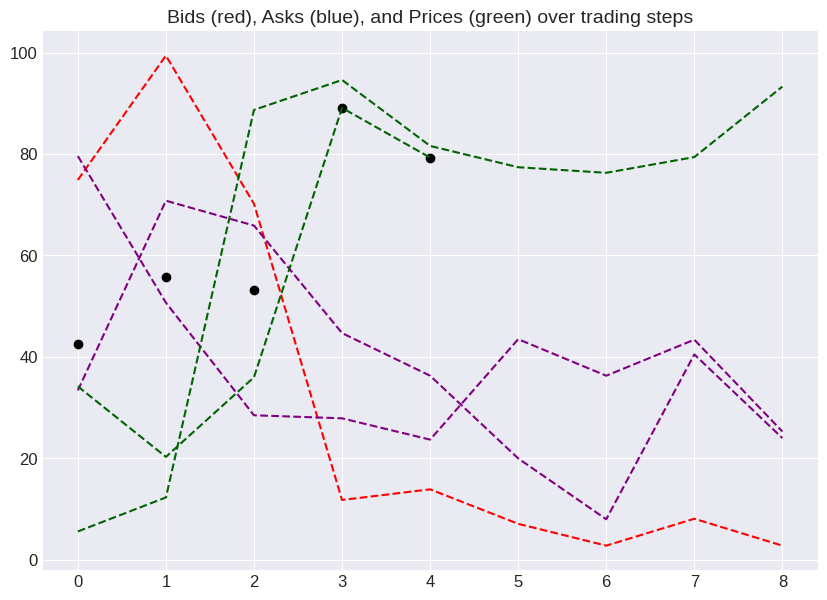

In [77]:
env.graphOffers(0,4999)

9
9


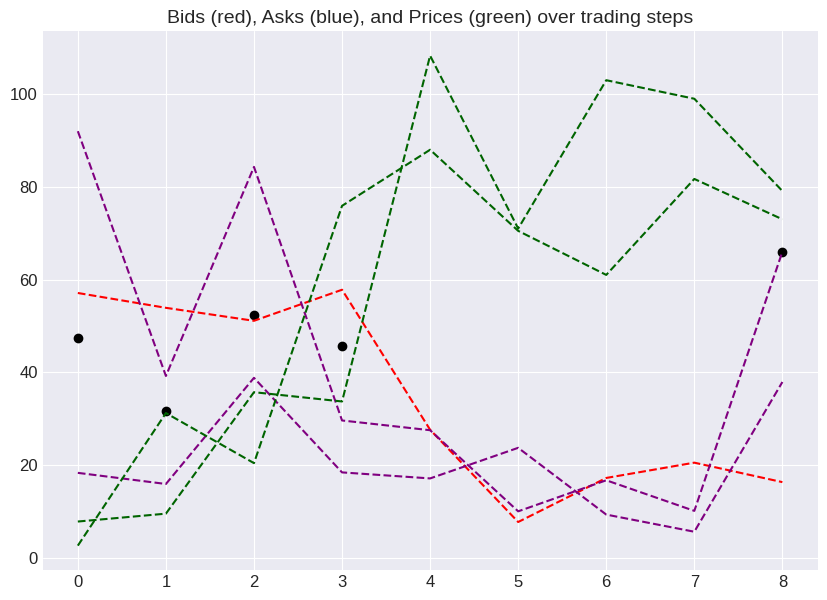

In [49]:
env.graphOffers(0,13050)

In [44]:
env.log.stepData.tail(9*200).groupby('currentBidIdx').sum()

,rnd,period,step,bids,asks,currentBid,currentAsk,currentAskIdx,buy,sell,price,sale,bprofit,sprofit
currentBidIdx,,,,,,,,,,,,,,
0,0,10169322,2723,"[62.4, 58.7, 7.2, 55.9, nan, 19.3, 19.6, nan, ...","[10.0, nan, 35.8, 87.3, nan, 36.5, 79.2, nan, ...",40169.9,26545.0,662.0,466,494,21941.50,525,22316.50,12558.20
1,0,8204257,1961,"[50.6, 67.9, 18.7, 58.6, 89.3, 25.6, 34.6, 47....","[21.4, nan, 32.5, 111.9, nan, 22.1, 82.0, nan,...",40737.6,21568.7,636.0,498,469,27092.90,531,20756.50,13802.60
2,0,5180521,2516,"[14.0, nan, 37.3, 18.8, nan, 22.3, 10.6, nan, ...","[77.7, nan, nan, 80.3, nan, nan, 104.2, nan, n...",12298.8,30320.2,220.0,1,1,33.35,1,11.75,13.95


In [45]:
env.log.stepData.tail(9*200).groupby('currentAskIdx').sum()

,rnd,period,step,bids,asks,currentBid,currentBidIdx,currentAsk,buy,sell,price,sale,bprofit,sprofit
currentAskIdx,,,,,,,,,,,,,,
0.0,0,11815442,3842,"[62.4, 58.7, 7.2, 50.6, 67.9, 18.7, 14.0, nan,...","[10.0, nan, 35.8, 21.4, nan, 32.5, 77.7, nan, ...",43956.0,805,48327.8,449,452,22245.75,480,20049.45,12585.75
2.0,0,9932523,2365,"[58.6, 89.3, 25.6, 34.6, 47.7, 13.5, 56.7, 74....","[111.9, nan, 22.1, 82.0, nan, 60.2, 8.9, nan, ...",40713.7,538,30106.1,516,512,26822.00,577,23035.30,13789.00


### Stablebaselines

In [212]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN, SAC
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy
eval_steps = 1000
training_step = 50000
env = SingleAgentEnv1(metaData)
policy_kwargs = dict(net_arch=dict(pi=[128, 128, 128], qf=[128, 128, 128]))
model = SAC("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,)
model.learn(training_step, progress_bar = True)

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16       |
|    ep_rew_mean     | 35.1     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 212      |
|    time_elapsed    | 0        |
|    total_timesteps | 64       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16       |
|    ep_rew_mean     | 33.4     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 146      |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
| train/             |          |
|    actor_loss      | -3.5     |
|    critic_loss     | 86.3     |
|    ent_coef        | 0.996    |
|    ent_coef_loss   | -0.0069  |
|    learning_rate   | 0.0003   |
|    n_updates       | 27       |
----------------------

KeyboardInterrupt: 

16

16

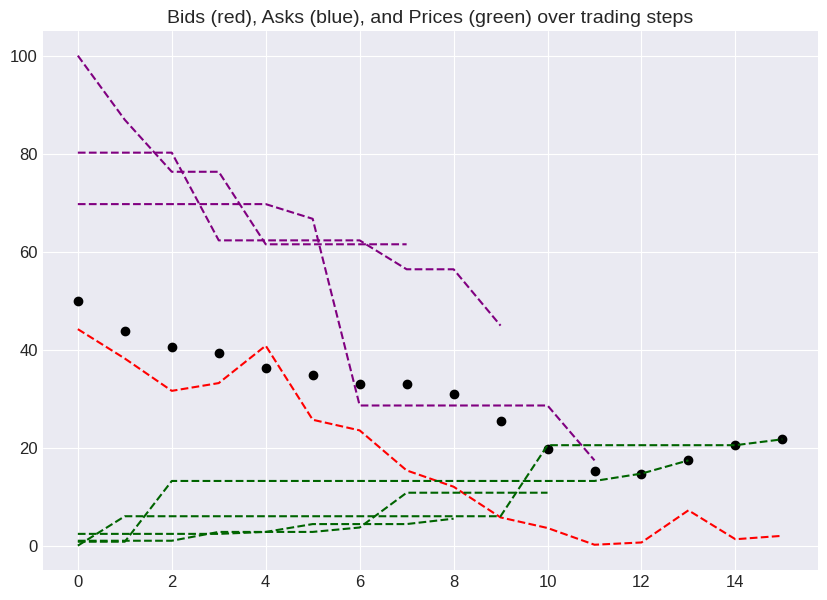

In [213]:
env.graphOffers(0,450)

In [214]:
env.log.getPeriod(0,450)

,rnd,period,step,bids,asks,currentBid,currentBidIdx,currentAsk,currentAskIdx,buy,sell,price,sale,bprofit,sprofit
7200,0,450,0,"[44.17999982833862, 80.2, 69.7, 100.0]","[0.8, 1.0, 2.4, 0.0]",100.000000,3,0.0,3,True,True,50.00,True,50.00,50.00
7201,0,450,1,"[38.18705677986145, 80.2, 69.7, 86.9]","[0.8, 1.0, 2.4, 6.0]",86.900000,3,0.8,0,True,True,43.85,True,43.05,43.05
7202,0,450,2,"[31.58971071243286, 80.2, 69.7, 76.3]","[13.2, 1.0, 2.4, 6.0]",80.200000,1,1.0,1,True,True,40.60,True,39.60,39.60
7203,0,450,3,"[33.173930644989014, 62.3, 69.7, 76.3]","[13.2, 2.8, 2.4, 6.0]",76.300000,3,2.4,2,True,True,39.35,True,36.95,36.95
7204,0,450,4,"[40.809863805770874, 62.3, 69.7, 61.5]","[13.2, 2.8, 2.8, 6.0]",69.700000,2,2.8,1,True,True,36.25,True,33.45,33.45
7205,0,450,5,"[25.69015622138977, 62.3, 66.7, 61.5]","[13.2, 4.4, 2.8, 6.0]",66.700000,2,2.8,2,True,True,34.75,True,31.95,31.95
7206,0,450,6,"[23.520880937576294, 62.3, 28.6, 61.5]","[13.2, 4.4, 3.7, 6.0]",62.300000,1,3.7,2,True,True,33.00,True,29.30,29.30
7207,0,450,7,"[15.351784229278564, 56.4, 28.6, 61.5]","[13.2, 4.4, 10.8, 6.0]",61.500000,3,4.4,1,True,True,32.95,True,28.55,28.55
7208,0,450,8,"[12.024950981140137, 56.4, 28.6, nan]","[13.2, 5.5, 10.8, 6.0]",56.400000,1,5.5,1,True,True,30.95,True,25.45,25.45
7209,0,450,9,"[5.7601988315582275, 44.9, 28.6, nan]","[13.2, nan, 10.8, 6.0]",44.900000,1,6.0,3,True,True,25.45,True,19.45,19.45
